# 14th April Notes

## Importing req libs

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


## A brief aside on using DataLoader

In [ ]:
data = sns.load_dataset("iris")

In [ ]:
data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
x = data.drop("species", axis=1)
y = data["species"]
x = torch.tensor(x.values).float()

In [ ]:
set(y)

{'setosa', 'versicolor', 'virginica'}

In [ ]:
y_label = np.zeros(len(y))
y_label[y == "versicolor"] = 1
y_label[y == "setosa"] = 2
y = torch.tensor(y_label)
y = y.to(torch.long)

In [ ]:
train_data, test_data, train_labels, test_labels = \
train_test_split(x, y, train_size=0.8)

In [ ]:
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

In [ ]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [ ]:
test_loader.batch_size

30

In [ ]:
for x, y in train_loader:
  print(x.shape, y.shape)

torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])


In [ ]:
def Model():
  model = nn.Sequential(
      nn.Linear(4, 64),
      nn.ReLU(),
      nn.Linear(64, 64),
      nn.ReLU(),
      nn.Linear(64, 3),
      nn.Softmax()
  )

  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

  return model, lossfun, optimizer

In [ ]:
# training the model

model, Loss, optimizer = Model()

train_acc = []
test_acc = []

for i in range(1000):
  batch_acc = []

  for x, y in train_loader:
    y_hat = model(x)
    loss = Loss(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
  train_acc.append(np.mean(batch_acc))
  x,  y = next(iter(test_loader))
  predlabels = torch.argmax(model(x), axis=1)
  test_acc.append(100 * torch.mean((predlabels==y).float()).item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


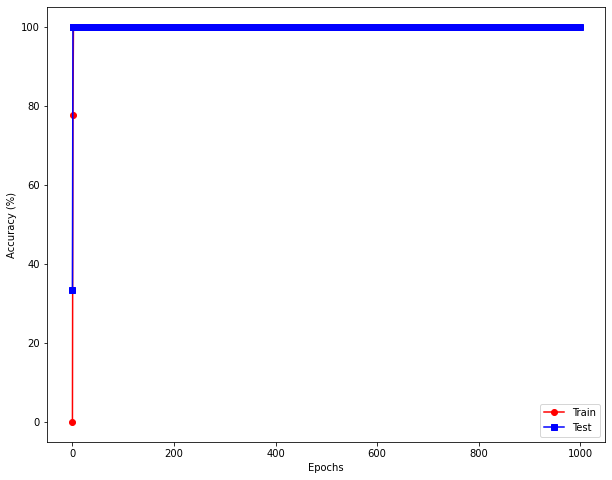

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.plot(train_acc, "ro-");
plt.plot(test_acc, "bs-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"])
plt.show()

In [ ]:
test_acc[-1]

100.0

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
display.set_matplotlib_formats("svg")

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Using DropOut

In [ ]:
pr = 0.5
dropout = nn.Dropout(p=pr)
x = torch.ones(10)
y = dropout(x)
y

tensor([0., 2., 2., 0., 0., 2., 2., 2., 2., 2.])

In [ ]:
torch.mean(y)

tensor(1.4000)

In [ ]:
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


## Create the data

In [ ]:
points = 200
th = np.linspace(0, 4 * np.pi, points)
r1 = 10
r2 = 15

a = [r1 * np.cos(th) + np.random.randn(points) * 3,
     r1 * np.sin(th) + np.random.randn(points)]
b = [r2 * np.cos(th) + np.random.randn(points),
     r2 * np.sin(th) + np.random.randn(points) * 3]

labels_np = np.vstack((np.zeros((points, 1)), np.ones((points, 1))))

# Concantante into a matrix
data_np = np.hstack((a, b)).T

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

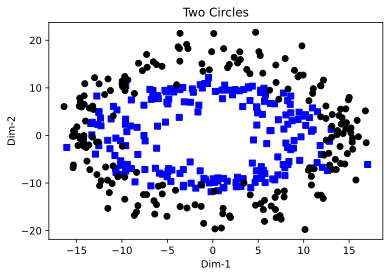

In [ ]:
fig = plt.plot(figsize=(6, 6))
plt.plot(data[np.where(labels == 0)[0], 0],
         data[np.where(labels == 0)[0], 1], "bs")
plt.plot(data[np.where(labels == 1)[0], 0],
         data[np.where(labels == 1)[0], 1], "ko")
plt.title("Two Circles")
plt.xlabel("Dim-1")
plt.ylabel("Dim-2")
plt.show()

## Separate the data into dataLoaders

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2
)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch = 16
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data,
                         batch_size=test_data.tensors[0].shape[0])

In [ ]:
class CreateModel(nn.Module):
  def __init__(self, dropout_rate):
    super().__init__()
    # Layers
    self.Input = nn.Linear(2, 128)
    self.Hidden = nn.Linear(128, 128)
    self.Output = nn.Linear(128, 1)
    # parameters
    self.dr = dropout_rate

    # forward pass
    def forward(self, x):
      x = F.relu(self.Input(x))
      x = F.dropout(x, p=self.dr, training=self.training)
      x = F.relu(self.Hidden(x))
      x = F.dropout(x, p=self.dr, training=self.training)
      x = self.Output(x)
      return x

In [ ]:
def createModel(dr):
  model = CreateModel(dr)
  Loss = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  return model, Loss, optimizer

In [ ]:
train_acc = []
test_acc = []

model, Loss, optimizer = createModel(0.25)

for i in range(1000):
  batch_acc = []
  for x, y in train_loader:
    y_hat = model(x)
    loss = Loss(y_hat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    batch_acc.append(100 * torch.mean(((y_hat > .5) == y).float()).item())
  train_acc.append(np.mean(batch_acc))
  model.eval()
  x, y = next(iter(test_loader))
  y_hat = model(x)
  test_acc.append(100 * torch.mean(((y_hat > .5) == y).float()).item())


## L2 regularization

In [ ]:
def annModel(l2):
  model = nn.Sequential(
      nn.Linear(4, 64),
      nn.ReLU(),
      nn.Linear(64, 64),
      nn.ReLU(),
      nn.Linear(64, 3),
      nn.Softmax()
  )

  Loss = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=l2)
  return model, Loss, optimizer

In [ ]:
annModel(1)

(Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=3, bias=True)
   (5): Softmax(dim=None)
 ), CrossEntropyLoss(), SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     momentum: 0
     nesterov: False
     weight_decay: 1
 ))

In [ ]:
def build(epochs=1000):
  train_acc = []
  test_acc = []
  losses = []
  model, Loss, optimizer = annModel(0.01)

  for i in range(epochs):
    batch_acc = []
    for x, y in train_loader:
      y_hat = model(x)
      loss = Loss(y_hat, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
    train_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
    model.eval()
    x, y = next(iter(test_loader))
    preds = torch.argmax(model(x), axis=1)
    test_acc.append(100 * torch.mean((preds == y).float()).item())
    model.train()
  return train_acc, test_acc

In [ ]:
a, b = build()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


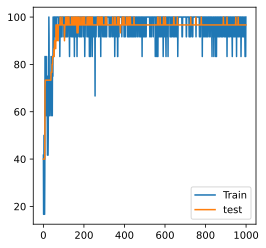

In [ ]:
fig = plt.figure(figsize=(4, 4))
plt.plot(a)
plt.plot(b)
plt.legend(["Train", "test"]);

In [ ]:
b[-1]

96.66666388511658

In [ ]:
a[-1]

100.0

## L1 Regularization

In [ ]:
def annModelNew(l2):
  model = nn.Sequential(
      nn.Linear(4, 64),
      nn.ReLU(),
      nn.Linear(64, 64),
      nn.ReLU(),
      nn.Linear(64, 3),
      nn.Softmax()
  )

  Loss = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
  return model, Loss, optimizer